In [1]:
# This project focuses on brain CT image segmentation and denoising using Deep Learning.
# Al Smith and Will Newman
# c 2024

# Importing the necessary libraries:
import pydicom
from collections import defaultdict
import numpy as np
import random
import os
import gc
from glob import glob
import nibabel as nib
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from ipywidgets import widgets, interact, IntSlider
from scipy.ndimage import label
from mayavi import mlab
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom
from scipy.ndimage import gaussian_filter


## Tasks:
1) Load data from CQ500
    * Download from: http://headctstudy.qure.ai/dataset
    * Explore the DICOM Header for voxel size and imaging information (ideally the CT machine model)
    * Resolution, dose, parameters, etc.
2) Preprocess the data (noise addition, downsampling, agumentation, etc)
    * 2a) Add noise similar to low-resolution CT
    * 2b) Downsample the images to lower-resolution scale
    * 2c) Split data into train/test sets
3) Build a 3D U-Net model for segmentation
    * 3a) start with training the model on CQ500 and normal masks
    * 3b) train the model on CQ500 with noise added
    * 3c) train the model on CQ500 with images processed by denoising model
4) Denoising Model for noisy CT images
5) Train the model
6) Evaluate the model

In [2]:
# Global Variables
lb = 1040
ub = 1080

In [3]:
def save_nifti(mask, output_dir, series_uid):
    """Save the mask as a NIfTI file."""
    nifti_image = nib.Nifti1Image(mask.astype(np.int16), affine=np.eye(4))
    nib.save(nifti_image, os.path.join(output_dir, f'{series_uid}_mask.nii'))

In [4]:
# Apply window and level to a 2D numpy array of DICOM data
def apply_window_level(data, lb, ub):
    windowed_data = np.clip(data, lb, ub)
    normalized_data = (windowed_data - lb) / (ub - lb)  # Normalize between 0 and 1
    return normalized_data

# Remove unnecessary CSF spaces from the mask
def remove_mask_below_slice(volume_mask, slice_index):
    """
    Set the mask to False for all slices below the specified index.

    Parameters:
    - volume_mask: 3D numpy array (boolean) of the mask.
    - slice_index: Integer, the index below which the mask should be removed.
    """
    # Set all slices below the specified index to False
    volume_mask[:slice_index, :, :] = False
    return volume_mask


In [5]:
# Largest connected component segmentation
def create_spherical_mask(shape, center, radius):
    z, y, x = np.ogrid[:shape[0], :shape[1], :shape[2]]
    dist_from_center = (z - center[0])**2 + (y - center[1])**2 + (x - center[2])**2
    return dist_from_center <= radius**2


def largest_connected_component_3d(volume_data, lb, center, radius, threshold=0.4):
    """
    Find the largest connected component in a 3D volume that intersects with a specified spherical region.

    Parameters:
    - volume_data: 3D numpy array of DICOM data.
    - lb: Lower bound to create a binary mask for values of interest.
    - center: Tuple, the center coordinates (z, y, x) of the volume.
    - radius: Integer, the radius used to define the spherical region.

    Returns:
    - 3D mask (boolean array) of the same shape as volume_data for the largest component intersecting the sphere.
    """
    # Generate the binary mask
    slice_index = int(volume_data.shape[0] * 0.4)
    binary_mask = volume_data < lb
    binary_mask = remove_mask_below_slice(binary_mask, slice_index)

    # Label all components
    labeled_volume, num_features = label(binary_mask)
    if num_features == 0:
        return np.zeros_like(volume_data, dtype=bool)  # No components found

    # Generate the spherical mask
    spherical_mask = create_spherical_mask(volume_data.shape, center, radius)

    # Find labels intersecting the spherical mask
    intersecting_labels = np.unique(labeled_volume[spherical_mask])

    # Calculate the size of each intersecting component and select the largest
    largest_label = None
    max_size = 0
    for label_idx in intersecting_labels:
        if label_idx == 0:
            continue  # Skip background
        component_mask = labeled_volume == label_idx
        component_size = np.sum(component_mask)
        if component_size > max_size:
            max_size = component_size
            largest_label = label_idx

    return labeled_volume == largest_label if largest_label is not None else np.zeros_like(volume_data, dtype=bool)


In [6]:
def load_dicom_series_volumes(base_directory, idx):
    series_volumes = defaultdict(list)
    # Track the number of DICOM files processed
    dicom_file_count = 0
    
    # Construct the directory path
    case_dir = os.path.join(base_directory, f"CQ500CT{idx} CQ500CT{idx}", "Unknown Study")
    
    if os.path.exists(case_dir):
        # Walk through all files in the series directories within the "Unknown Study" directory
        for root, dirs, files in os.walk(case_dir):
            for dir in dirs:
                series_path = os.path.join(root, dir)
                slices = []
                # Collect all DICOM slices in the series directory
                for slice_file in os.listdir(series_path):
                    if slice_file.lower().endswith('.dcm'):
                        full_path = os.path.join(series_path, slice_file)
                        try:
                            # Read the DICOM file
                            dicom_slice = pydicom.dcmread(full_path)
                            # Append the slice and its position for later sorting
                            slices.append((dicom_slice, dicom_slice.ImagePositionPatient[2]))
                            dicom_file_count += 1
                        except Exception as e:
                            print(f"Failed to read {slice_file} as DICOM: {e}")

                # Sort slices based on the z-coordinate (ImagePositionPatient[2])
                slices.sort(key=lambda x: x[1])
                # Stack the pixel data from sorted slices to form a 3D volume
                if slices:
                    series_uid = slices[0][0].SeriesInstanceUID
                    volume = np.stack([s[0].pixel_array for s in slices])
                    series_volumes[series_uid].append(volume)

                    center = (volume.shape[0] // 2, volume.shape[1] // 2, volume.shape[2] // 2)
                    radius = int(volume.shape[0] // 6)  # Define the radius as desired

                    # Generate mask and save
                    mask = remove_mask_below_slice(largest_connected_component_3d(volume, lb, center, radius), volume.shape[0] * 2 // 5)
                    save_nifti(mask, case_dir, series_uid)
                    print("Saved mask to ", case_dir)
    else:
        print(f"Directory does not exist: {case_dir}")

    print(f"Processed {dicom_file_count} DICOM files.")
    return series_volumes

# Usage example
base_directory = '/media/hal9000/Database/CQ500_extracted'  # Adjust this path
dicom_volumes = load_dicom_series_volumes(base_directory, 0)
print(f"Number of series with loaded volumes: {len(dicom_volumes)}")

Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Processed 987 DICOM files.
Number of series with loaded volumes: 5


# DICOM Directories that are useful
* Series Number    0, 3, 4, 5, 7, 9, 14, 15, 19, 23, 26, 28, 33, 36, 37, 39, 40, 41, 43, 45, 46, 50, 56, 58, 59, 62, 63, 64, 70, 71, 76, 78, 79, 81, 82, 83, 84, 85, 89, 91, 92, 99, 100, 101, 102, 103, 104, 105, 106, 109, 113, 116, 117
* Number of Masks: 5, 2, 1, 1, 1, 2,  2,  1,  4,  2,  3,  2,  2,  3,  2,  2,  2,  1,  1,  1,  1,  1,  2,  3,  1,  2,  2,  3,  1,  2,  2, 1,   1,   1,  1,  1,  1,  3,  3,  1,  4,  1,   2,   3,   1,   2,   1,   3,   4,   2,   2,   1,   3

# DICOM Directories with surgical pathology (less useful)
* Series Number    2, 6, 10, 11, 17, 18, 20, 22, 34, 48, 55, 57, 60, 64, 66, 68, 86, 90, 108, 111, 114,
* Number of Masks: 2, 3,  1,  2,  2,  2,  2,  2,  3,  4,  2,  2,  4,  1,  5,  1,  2,  2,   2,   2,   1,

In [63]:
# Visualize Loaded DICOM Data

# Assume dicom_volumes is already loaded
series_selection =  1
dicom =             0
series_uid = list(dicom_volumes.keys())[series_selection]
print(series_uid)
volume = dicom_volumes[series_uid][0]  # Get the first volume of the first series

center = (volume.shape[0] // 2, volume.shape[1] // 2, volume.shape[2] // 2)
radius = int(volume.shape[0] // 6)  # Define the radius as desired
#volume_mask = remove_mask_below_slice(largest_connected_component_3d(volume, lb, center, radius), volume.shape[0] * 2 // 5)
volume_mask = nib.load(f'/media/hal9000/Database/CQ500_extracted/CQ500CT{dicom} CQ500CT{dicom}/Unknown Study/{series_uid}_mask.nii').get_fdata() > 0

# Function to display a single slice
def view_slice(slice_index):
    plt.figure(figsize=(4, 4))
    processed_image = apply_window_level(volume[slice_index], lb, ub)
    
    # Overlay the 3D mask on the corresponding slice
    overlay = np.zeros(processed_image.shape + (4,))  # RGBA
    overlay[..., 0] = 1.0  # Red channel
    overlay[..., 3] = volume_mask[slice_index] * 0.5  # Semi-transparent where the mask is True

    plt.imshow(processed_image, cmap='gray')
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f'Slice {slice_index + 1}')
    plt.show()

# Slider to select the slice index
slice_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=volume.shape[0] - 1,  # max slice index
    step=1,
    description='Slice Index:',
    continuous_update=True
)

# Use ipywidgets' interactive functionality to bind the slider and the display function
widgets.interactive(view_slice, slice_index=slice_slider)

1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110


interactive(children=(IntSlider(value=0, description='Slice Index:', max=238), Output()), _dom_classes=('widge…

In [9]:
# Visualize the CSF Space Segmentation Mask in 3D dynamic viewer
def visualize_3d_mask(volume_mask):
    """Visualize a 3D mask using mayavi's volume rendering capabilities."""
    # Create a figure
    fig = mlab.figure(bgcolor=(0, 0, 0), size=(800, 800))
    
    # Visualize the volume mask: 1s are turned to True, 0s to False
    src = mlab.pipeline.scalar_field(zoom(volume_mask.astype(int), (4, 1, 1)))
    # Threshold to visualize only the 1s
    mlab.pipeline.iso_surface(src, contours=[volume_mask.min()+0.5, volume_mask.max()], opacity=0.4, color=(1, 0, 0))
    
    # Enhance the view
    mlab.view(azimuth=180, elevation=180, distance=400)
    mlab.roll(180)
    
    # Add axes and outline for better visual orientation
    mlab.outline(src, color=(1, 1, 1))
    mlab.axes(src, color=(1, 1, 1), xlabel='X', ylabel='Y', zlabel='Z')

    # Show the plot
    mlab.show()

# Assuming volume_mask is the mask calculated earlier
visualize_3d_mask(volume_mask)

In [10]:
# SAVE SLICES AS IMAGES (convert to GIF online)
# Assume dicom_volumes is already loaded
series_selection =  3
dicom =             0
series_uid = list(dicom_volumes.keys())[series_selection]
print(series_uid)
volume = dicom_volumes[series_uid][0]  # Get the first volume of the first series

# Create a directory to save the images
output_dir = './output_images'
os.makedirs(output_dir, exist_ok=True)

# Function to save a single slice as an image
def save_slice(slice_index):
    plt.figure(figsize=(4, 4))
    processed_image = apply_window_level(volume[slice_index], lb, ub)
    
    # Overlay the 3D mask on the corresponding slice
    overlay = np.zeros(processed_image.shape + (4,))  # RGBA
    overlay[..., 0] = 1.0  # Red channel
    overlay[..., 3] = volume_mask[slice_index] * 0.5  # Semi-transparent where the mask is True

    plt.imshow(processed_image, cmap='gray')
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f'Slice {slice_index + 1}')
    
    # Save the figure
    plt.savefig(os.path.join(output_dir, f'slice_{slice_index + 1}.png'))
    plt.close()

# Save all slices as images
for slice_index in range(volume.shape[0]):
    save_slice(slice_index)

1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075


In [13]:
# Task #1 Convert loaded data into torch training and validation datasets
def load_dicom_series_volumes(base_directory, indices, target_size=(32, 128, 128)):
    series_data = defaultdict(lambda: {'images': None, 'mask': None})

    for idx in indices:
        case_dir = os.path.join(base_directory, f"CQ500CT{idx} CQ500CT{idx}", "Unknown Study")
        print(f"Searching in: {case_dir}")

        if os.path.exists(case_dir):
            mask_files = {os.path.basename(f).split('_mask.nii')[0]: f for f in glob(os.path.join(case_dir, '*_mask.nii'))}

            for subdir in os.listdir(case_dir):
                subdir_path = os.path.join(case_dir, subdir)
                if not os.path.isdir(subdir_path):
                    continue

                slices = []
                series_uid = None
                for slice_file in glob(os.path.join(subdir_path, '*.dcm')):
                    try:
                        dicom_slice = pydicom.dcmread(slice_file)
                        slices.append(dicom_slice)
                        series_uid = dicom_slice.SeriesInstanceUID
                    except Exception as e:
                        print(f"Failed to read {slice_file} as DICOM: {e}")

                if slices and series_uid:
                    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
                    volume = np.stack([s.pixel_array for s in slices])

                    # Resize the volume
                    resize_factor = np.array(target_size) / np.array(volume.shape)
                    resized_volume = zoom(volume, resize_factor)
                    series_data[series_uid]['images'] = resized_volume

                    if series_uid in mask_files:
                        mask_file = mask_files[series_uid]
                        mask = nib.load(mask_file).get_fdata()

                        # Resize the mask
                        resized_mask = zoom(mask, resize_factor)
                        resized_mask = (resized_mask > 0.5).astype(np.float32)
                        series_data[series_uid]['mask'] = resized_mask
                        print(f"Mask found and loaded for series UID {series_uid}")
        else:
            print(f"No directory found for index {idx}")

    filtered_data = {uid: data for uid, data in series_data.items() if data['images'] is not None and data['mask'] is not None}
    return filtered_data

# Usage example
base_directory = '/media/hal9000/Database/CQ500_extracted/'
# all indices from "good scans", where first comment is 10 scans, second is 64, and third is 100, spaces indicate where to comment out
indices = [0, 3, 4, 5, 7, \
           9, 14, 15, 19, 23, 26, 28, 33, 36, 37, 39, 40, 41, 43, 45, 46, 50, 56, 58, 59, 62, 63, \
           64, 70, 71, 76, 78, 79, 81, 82, 83, 84, \
           85, 89, 91, 92, 99, 100, 101, 102, 103, 104, 105, 55, 109, 113, 116, 117]
loaded_data = load_dicom_series_volumes(base_directory, indices)
print(f"Loaded {len(loaded_data)} series with both images and masks.")

Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714313.2033589
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT3 CQ500CT3/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713849.1919689
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713848.1919208
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT4 CQ500CT4/Unknown Study


/home/hal9000/.local/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (16-bit) doesn't match the JPEG 2000 data (14-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/home/hal9000/.local/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (16-bit) doesn't match the JPEG 2000 data (13-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713544.1838788
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT5 CQ500CT5/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713672.1872547
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT7 CQ500CT7/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713385.1794631
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT9 CQ500CT9/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713737.1889019
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713734.1888437
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT14 CQ500CT14/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714487.2066237
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714484.2065631
Searching 

/home/hal9000/.local/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (11-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713857.1921895
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT43 CQ500CT43/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714173.2003120
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT45 CQ500CT45/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713842.1917402
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT46 CQ500CT46/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714540.2075073
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT50 CQ500CT50/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713549.1840468
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT56 CQ500CT56/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714233.2015756
Mask fou

In [27]:
# Make sure images are loaded correctly

def visualize_images_and_masks(image_volume, mask_volume):
    """
    Visualize DICOM images with their corresponding masks using matplotlib and ipywidgets.

    Parameters:
    - image_volume: 3D numpy array of the DICOM images.
    - mask_volume: 3D numpy array of the mask data.
    """

    image_volume = np.clip(image_volume, lb, ub)  # Apply window and level

    # Create a colormap that includes transparency
    colors = [(0,0,0,0)] + [(plt.cm.Reds(i)) for i in range(1,256)]
    RedAlpha = mcolors.LinearSegmentedColormap.from_list('RedAlpha', colors, N=256)

    # Function to update the plot for each slice
    def plot_slice(slice_index):
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
        # Show the mask slice
        ax.imshow(image_volume[slice_index], cmap='gray')
        ax.imshow(mask_volume[slice_index], alpha=0.75, cmap=RedAlpha)  # Overlay mask
        ax.set_title('Image with Mask')
        ax.axis('off')

        plt.show()

    # Create a slider to scroll through slices
    interact(plot_slice, slice_index=IntSlider(min=0, max=image_volume.shape[0] - 1, step=1, value=image_volume.shape[0] // 2))

# Example usage with the first loaded series (assuming loaded_data is available)
series_uid = random.choice(list(loaded_data.keys()))    # Randomly select a series
print(series_uid)
visualize_images_and_masks(loaded_data[series_uid]['images'], loaded_data[series_uid]['mask'])

1.2.276.0.7230010.3.1.3.296485376.1.1521714084.1984457


interactive(children=(IntSlider(value=16, description='slice_index', max=31), Output()), _dom_classes=('widget…

In [28]:
class CTScanDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        uid, data = list(self.data.items())[idx]
        image = np.array(data['images'])  # Convert memmap to regular numpy array
        mask = np.array(data['mask'])  # Convert memmap to regular numpy array
        return image, mask

In [30]:
# Define a custom collate function

batch_size = 6

def collate_fn(batch):
    images, masks = zip(*batch)
    
    # Convert the numpy arrays to PyTorch tensors
    images = [torch.from_numpy(image.astype(np.float32)) for image in images]
    masks = [torch.from_numpy(mask.astype(np.uint8)) for mask in masks]
    
    # Determine the maximum size along the 0 axis
    max_size = max(image.shape[0] for image in images)
    
    # Pad the images and masks to the maximum size
    images = [F.pad(image.float(), (0, 0, 0, 0, 0, max_size - image.shape[0])) for image in images]
    masks = [F.pad(mask.float(), (0, 0, 0, 0, 0, max_size - mask.shape[0])) for mask in masks]
    
    return torch.stack(images), torch.stack(masks)

# Data Split
def create_train_test_split(data_dict, test_size=0.25, random_state=42):
    # Create a list of keys, which are the series UIDs
    series_uids = list(data_dict.keys())
    
    # Split the series UIDs into train and test sets
    train_uids, test_uids = train_test_split(series_uids, test_size=test_size, random_state=random_state)
    
    # Create subsets for train and test from the main dataset
    train_dataset = {uid: data_dict[uid] for uid in train_uids}
    test_dataset = {uid: data_dict[uid] for uid in test_uids}
    
    return train_dataset, test_dataset

# Assume 'loaded_data' is your fully loaded dataset dictionary
train_data, test_data = create_train_test_split(loaded_data, test_size=0.4)

# Assuming a transform defined earlier
train_dataset = CTScanDataset(train_data)
test_dataset = CTScanDataset(test_data)

# Create DataLoaders for both train and test datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Task #2 Preprocess the data
# Task #2b Add noise similar to low-resolution CT

# Task #2c Downsample the images to lower-resolution scale

# Task #2d Split the data into training and testing sets

In [ ]:
# Task #3 Build a 3D U-Net model for segmentation
# Task #3a Start with training the model on CQ500 and normal masks

# Task #3b Train the model on CQ500 with noise added

# Task #3c Train the model on CQ500 with images processed by denoising model

In [71]:
# Task 3 Using nnU-Net architecture as described in the paper: https://arxiv.org/abs/2404.09556

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffZ = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffY = torch.tensor([x2.size()[3] - x1.size()[3]])
        diffX = torch.tensor([x2.size()[4] - x1.size()[4]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2,
                        diffZ // 2, diffZ - diffZ // 2])
        # if you have padding issues, see below
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.up1 = Up(768, 256, bilinear)
        self.up2 = Up(384, 128, bilinear)
        self.up3 = Up(192, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

In [72]:
# Use Sørensen-Dice coefficient as the loss function
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Convert probabilities to binary predictions
        # For a multi-class problem, consider each class channel as a binary problem
        inputs = torch.sigmoid(inputs)  # Apply sigmoid to squash outputs to [0,1]
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

In [205]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model = UNet3D(n_channels=1, n_classes=1).to(device)
#criterion = DiceLoss()
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 200
loss = 0.0
loss_history = []
val_loss_history = []
def to_grayscale(images):
    return images.mean(dim=1, keepdim=True).squeeze(1)

Device:  cuda


In [204]:
# garbace collection to prevent gpu memory overflow
gc.collect()
model = None
torch.cuda.empty_cache()

In [75]:
# Training Loop
squeeze_factor = 1
num_epochs = 125 # Set this to your desired number of epochs

progress_bar_epochs = tqdm(range(num_epochs), total=num_epochs, desc="Training Progress")

for epoch in progress_bar_epochs:
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_val_loss = 0.0

    for i, (images, masks) in enumerate(train_loader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        images = images.unsqueeze(squeeze_factor)
        masks = masks.unsqueeze(squeeze_factor)

        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=images.size()[2:])
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        del images, masks, outputs
        torch.cuda.empty_cache()

    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_history.append(average_loss)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        running_val_loss = 0.0
        for i, (images, masks) in enumerate(test_loader):
            images = images.float().to(device)
            masks = masks.float().to(device)
            
            images = images.unsqueeze(squeeze_factor)
            masks = masks.unsqueeze(squeeze_factor)

            # Forward pass
            outputs = model(images)
            val_loss = criterion(outputs, masks)

            running_val_loss += val_loss.item()

        # Calculate the average validation loss for the epoch
        average_val_loss = running_val_loss / len(test_loader)
        val_loss_history.append(average_val_loss)

    # Print losses every epoch
    progress_bar_epochs.set_postfix({'Epoch': epoch+1, 'Avg Loss': average_loss, 'Avg Val Loss': average_val_loss})

Training Progress: 100%|██████████| 125/125 [45:01<00:00, 21.62s/it, Epoch=125, Avg Loss=0.369, Avg Val Loss=0.435]


In [211]:
# Training Loop
squeeze_factor = 1
num_epochs = 10 # Set this to your desired number of epochs

progress_bar_epochs = tqdm(range(num_epochs), total=num_epochs, desc="Training Progress")

for epoch in progress_bar_epochs:
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_val_loss = 0.0

    for i, (images, masks) in enumerate(train_loader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        images = images.unsqueeze(squeeze_factor)
        masks = masks.unsqueeze(squeeze_factor)

        # Clip the images to the lower and upper bounds
        images = torch.clamp(images, lb, ub)

        # Normalize the images to the range [0, 1]
        images = (images - lb) / (ub - lb)

        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=images.size()[2:])
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        del images, masks, outputs
        torch.cuda.empty_cache()

    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_history.append(average_loss)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        running_val_loss = 0.0
        for i, (images, masks) in enumerate(test_loader):
            images = images.float().to(device)
            masks = masks.float().to(device)
            
            images = images.unsqueeze(squeeze_factor)
            masks = masks.unsqueeze(squeeze_factor)

            # Clip the images to the lower and upper bounds
            images = torch.clamp(images, lb, ub)

            # Normalize the images to the range [0, 1]
            images = (images - lb) / (ub - lb)

            # Forward pass
            outputs = model(images)
            val_loss = criterion(outputs, masks)

            running_val_loss += val_loss.item()

        # Calculate the average validation loss for the epoch
        average_val_loss = running_val_loss / len(test_loader)
        val_loss_history.append(average_val_loss)

    # Print losses every epoch
    progress_bar_epochs.set_postfix({'Epoch': epoch+1, 'Avg Loss': average_loss, 'Avg Val Loss': average_val_loss})

Training Progress: 100%|██████████| 10/10 [03:44<00:00, 22.41s/it, Epoch=10, Avg Loss=0.357, Avg Val Loss=0.381]


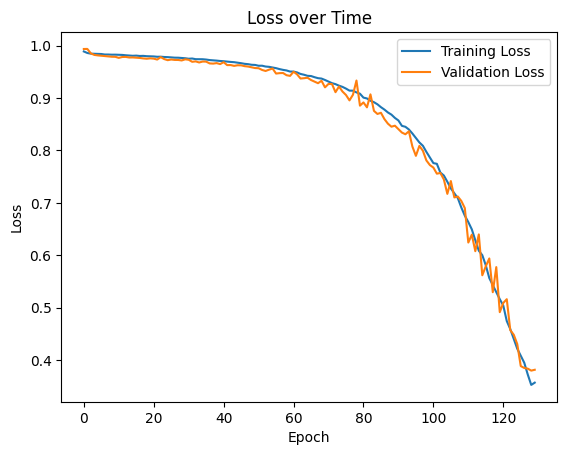

In [212]:
# Plotting the loss history and validation loss history
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.legend()
plt.show()


In [226]:
# Make sure images are loaded correctly

def visualize_images_and_masks(image_volume, mask_volume, pred_mask_volume):
    """
    Visualize DICOM images with their corresponding masks using matplotlib and ipywidgets.

    Parameters:
    - image_volume: 3D numpy array of the DICOM images.
    - mask_volume: 3D numpy array of the mask data.
    """

    image_volume = np.clip(image_volume, lb, ub)

    # Create a colormap that includes transparency
    colors = [(0,0,0,0)] + [(plt.cm.Reds(i)) for i in range(1,256)]
    RedAlpha = mcolors.LinearSegmentedColormap.from_list('RedAlpha', colors, N=256)

    colors = [(0,0,0,0)] + [(plt.cm.Blues(i)) for i in range(1,256)]
    BlueAlpha = mcolors.LinearSegmentedColormap.from_list('BlueAlpha', colors, N=256)

    # Function to update the plot for each slice
    def plot_slice(slice_index):
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        
        # Show the ground truth mask slice
        axs[0].imshow(image_volume[slice_index], cmap='gray')
        axs[0].imshow(mask_volume[slice_index], alpha=0.75, cmap=RedAlpha)  # Overlay mask
        axs[0].set_title('Image with Ground Truth Mask')
        axs[0].axis('off')

        # Show the predicted mask slice
        axs[1].imshow(image_volume[slice_index], cmap='gray')
        axs[1].imshow(pred_mask_volume[slice_index], alpha=0.75, cmap=BlueAlpha)  # Overlay mask
        axs[1].set_title('Image with Predicted Mask')
        axs[1].axis('off')

        plt.show()

    # Create a slider to scroll through slices
    interact(plot_slice, slice_index=IntSlider(min=0, max=image_volume.shape[0] - 1, step=1, value=image_volume.shape[0] // 2))

series_uid = random.choice(list(loaded_data.keys()))    # Randomly select a series

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    images = torch.from_numpy(loaded_data[series_uid]['images'].astype(np.float32)).clip(lb, ub)
    # Normalize the images to the range [0, 1]
    images = (images - lb) / (ub - lb)
    # Add a channel dimension (assuming grayscale images)
    images = images.unsqueeze(0)
    # Add a batch dimension
    images = images.unsqueeze(0)
    # Ensure the tensor is on the correct device
    images = images.to(device)
    outputs = model(images)  # Get the model's predictions

# The outputs are likely in the form of logits or probabilities. 
# You might need to apply a threshold or take the argmax to get the final predicted mask.
# This depends on how your model was trained.

pred_mask_volume = (outputs > 1).float().squeeze(0)[0].cpu().numpy()  # Example for a multi-class segmentation model

visualize_images_and_masks(loaded_data[series_uid]['images'], loaded_data[series_uid]['mask'], pred_mask_volume)

interactive(children=(IntSlider(value=16, description='slice_index', max=31), Output()), _dom_classes=('widget…

In [14]:
def load_dicom_series_volumes(base_directory, idx, target_size=(32, 128, 128)):
    series_volumes = defaultdict(list)
    # Track the number of DICOM files processed
    dicom_file_count = 0
    
    # Construct the directory path
    case_dir = os.path.join(base_directory, f"CQ500CT{idx} CQ500CT{idx}", "Unknown Study")
    
    if os.path.exists(case_dir):
        # Walk through all files in the series directories within the "Unknown Study" directory
        for root, dirs, files in os.walk(case_dir):
            for dir in dirs:
                series_path = os.path.join(root, dir)
                slices = []
                # Collect all DICOM slices in the series directory
                for slice_file in os.listdir(series_path):
                    if slice_file.lower().endswith('.dcm'):
                        full_path = os.path.join(series_path, slice_file)
                        try:
                            # Read the DICOM file
                            dicom_slice = pydicom.dcmread(full_path)
                            # Append the slice and its position for later sorting
                            slices.append((dicom_slice, dicom_slice.ImagePositionPatient[2]))
                            dicom_file_count += 1
                        except Exception as e:
                            print(f"Failed to read {slice_file} as DICOM: {e}")

                # Sort slices based on the z-coordinate (ImagePositionPatient[2])
                slices.sort(key=lambda x: x[1])
                # Stack the pixel data from sorted slices to form a 3D volume
                if slices:
                    series_uid = slices[0][0].SeriesInstanceUID
                    volume = np.stack([s[0].pixel_array for s in slices])

                    # Resize the volume
                    resize_factor = np.array(target_size) / np.array(volume.shape)
                    resized_volume = zoom(volume, resize_factor)
                    series_volumes[series_uid].append(resized_volume)

    else:
        print(f"Directory does not exist: {case_dir}")

    print(f"Processed {dicom_file_count} DICOM files.")
    return series_volumes

# Usage example
base_directory = '/media/hal9000/Database/CQ500_extracted'  # Adjust this path
dicom_volumes = load_dicom_series_volumes(base_directory, 200)
print(f"Number of series with loaded volumes: {len(dicom_volumes)}")

Processed 324 DICOM files.
Number of series with loaded volumes: 2


In [16]:
# Initialize the mask data dictionary
mask_data = {}

In [159]:
# Load data from NII files (Brain0 clipped data)
# load nii files from Will's folder, update mask_dir and brain_dir to update lists.

# Define the directories
brain_dir = './Noise Data/Brain0'
mask_dir = '/media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0'

# Define the target shape
target_shape = (32, 128, 128)

# Initialize the dictionary
brain_data = {"AE": {}, "FBP": {}, "GT": {}, "Noisy": {}, "VAE": {}}

# Define the correspondence between the file names and the series_uids
folder_to_series_uid = {
    "CTD3D": "1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152",
    "CTD3D2": "1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110",
    "CTD3D3": "1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631",
    "CTP": "1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075"
}

# Load the brain data
for key in brain_data.keys():
    subdir_path = os.path.join(brain_dir, key)
    if os.path.isdir(subdir_path):
        for root, dirs, files in os.walk(subdir_path):
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                for file in os.listdir(dir_path):
                    if file.endswith('.nii'):
                        img = nib.load(os.path.join(dir_path, file))
                        data = img.get_fdata()
                        resized_data = zoom(data, (target_shape[0]/data.shape[0], target_shape[1]/data.shape[1], target_shape[2]/data.shape[2]))
                        series_uid = folder_to_series_uid.get(dir)  # Get the series_uid from the dictionary using the directory name
                        if series_uid:  # If the series_uid exists
                            brain_data[key][series_uid] = resized_data  # Store the resized data in the dictionary with the series_uid as the key
                            print(f"Loaded data for {key} from {file} and associated with {series_uid}")


# Load the mask data
for root, dirs, files in os.walk(mask_dir):
    for file in files:
        if file.endswith('.nii'):
            series_uid = file.split('_')[0]  # Extract the series_uid from the file name
            img = nib.load(os.path.join(root, file))
            data = img.get_fdata()
            resized_data = zoom(data, (target_shape[0]/data.shape[0], target_shape[1]/data.shape[1], target_shape[2]/data.shape[2]))
            mask_data[series_uid] = resized_data  # Store the resized data in the dictionary with the series_uid as the key
            print(f"Loaded mask data for {series_uid}")

# Initialize the dictionary
data_dict = {"AE": {}, "FBP": {}, "GT": {}, "Noisy": {}, "VAE": {}}

# Iterate over the brain data and mask data to create the tuples
for key in data_dict.keys():
    for series_uid, brain in brain_data[key].items():
        mask = mask_data.get(series_uid)
        if mask is not None:
            data_dict[key][series_uid] = (brain, mask, None)  # Add a placeholder for the predicted mask values


Loaded data for AE from CT1.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075
Loaded data for AE from CT1.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110
Loaded data for AE from CT1.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152
Loaded data for AE from CT1.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631
Loaded data for FBP from CT1.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075
Loaded data for FBP from CT1.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110
Loaded data for FBP from CT1.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152
Loaded data for FBP from CT1.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631
Loaded data for GT from CT1.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075
Loaded data for GT from CT1.nii a

In [114]:
# Load data from NII files (new expanded version)
# load nii files from Will's folder, update mask_dir and brain_dir to update lists.

# Define the directories
brain_dir = './Noise Data/B0_expanded'
mask_dir = '/media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0'

# Define the target shape
target_shape = (32, 128, 128)

# Initialize the dictionary
brain_data = {"AE": {}, "FBP": {}, "GT": {}, "Noisy": {}, "VAE": {}}

# Define the correspondence between the file names and the series_uids
file_to_series_uid = {
    "CT 4cc sec 150cc D3D on.nii": "1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152",
    "CT 4cc sec 150cc D3D on-2.nii": "1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110",
    "CT 4cc sec 150cc D3D on-3.nii": "1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631",
    "CT Plain.nii": "1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075"
}

# Load the brain data
for key in brain_data.keys():
    subdir_path = os.path.join(brain_dir, key)
    if os.path.isdir(subdir_path):
        for root, dirs, files in os.walk(subdir_path):
            for file in sorted(files):
                if file.endswith('.nii'):
                    img = nib.load(os.path.join(root, file))
                    data = img.get_fdata()
                    resized_data = zoom(data, (target_shape[0]/data.shape[0], target_shape[1]/data.shape[1], target_shape[2]/data.shape[2]))
                    series_uid = file_to_series_uid.get(file)  # Get the series_uid from the dictionary
                    if series_uid:  # If the series_uid exists
                        brain_data[key][series_uid] = resized_data  # Store the resized data in the dictionary with the series_uid as the key
                        print(f"Loaded data for {key} from {file} and associated with {series_uid}")


# Load the mask data
for root, dirs, files in os.walk(mask_dir):
    for file in files:
        if file.endswith('.nii'):
            series_uid = file.split('_')[0]  # Extract the series_uid from the file name
            img = nib.load(os.path.join(root, file))
            data = img.get_fdata()
            resized_data = zoom(data, (target_shape[0]/data.shape[0], target_shape[1]/data.shape[1], target_shape[2]/data.shape[2]))
            mask_data[series_uid] = resized_data  # Store the resized data in the dictionary with the series_uid as the key
            print(f"Loaded mask data for {series_uid}")

# Initialize the dictionary
data_dict = {"AE": {}, "FBP": {}, "GT": {}, "Noisy": {}, "VAE": {}}

# Iterate over the brain data and mask data to create the tuples
for key in data_dict.keys():
    for series_uid, brain in brain_data[key].items():
        mask = mask_data.get(series_uid)
        if mask is not None:
            data_dict[key][series_uid] = (brain, mask, None)  # Add a placeholder for the predicted mask values

Loaded data for AE from CT 4cc sec 150cc D3D on-2.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110
Loaded data for AE from CT 4cc sec 150cc D3D on-3.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631
Loaded data for AE from CT 4cc sec 150cc D3D on.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152
Loaded data for AE from CT Plain.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075
Loaded data for FBP from CT 4cc sec 150cc D3D on-2.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110
Loaded data for FBP from CT 4cc sec 150cc D3D on-3.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631
Loaded data for FBP from CT 4cc sec 150cc D3D on.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152
Loaded data for FBP from CT Plain.nii and associated with 1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075
Lo

In [ ]:
# CTD3D     1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152
# CTD3D2    1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110
# CTD3D3    1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631
# CTP       1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075

In [172]:
def dice_coef(pred, target, smooth = 1.):
    """
    This function calculates the Dice loss between two binary masks.

    Parameters:
    - pred: The predicted mask.
    - target: The ground truth mask.
    - smooth: A smoothing factor to avoid division by zero.

    Returns:
    - The Dice loss between the predicted and ground truth masks.
    """
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    
    return loss.mean()

In [201]:
def visualize_all_masks(image_volume, mask_volume, ae_volume, ae_mask_volume, fbp_volume, fbp_mask_volume, gt_volume, gt_mask_volume, noisy_volume, noisy_mask_volume, vae_volume, vae_mask_volume):
    # Create a colormap that includes transparency
    colors = [(0,0,0,0)] + [(plt.cm.Reds(i)) for i in range(1,256)]
    RedAlpha = mcolors.LinearSegmentedColormap.from_list('RedAlpha', colors, N=256)

    colors = [(0,0,0,0)] + [(plt.cm.Blues(i)) for i in range(1,256)]
    BlueAlpha = mcolors.LinearSegmentedColormap.from_list('BlueAlpha', colors, N=256)

    # Function to update the plot for each slice
    def plot_slice(slice_index):
        fig, axs = plt.subplots(1, 6, figsize=(18, 3))
        
        # Show the ground truth mask slice
        axs[0].imshow(image_volume[slice_index], cmap='gray')
        axs[0].imshow(mask_volume[slice_index], alpha=0.75, cmap=RedAlpha)  # Overlay mask
        axs[0].set_title('Ground Truth')
        axs[0].axis('off')

        # Show the FBP mask slice
        axs[1].imshow(ae_volume[slice_index], cmap='gray')
        axs[1].imshow(ae_mask_volume[slice_index], alpha=0.75, cmap=BlueAlpha)  # Overlay mask
        axs[1].set_title(f'AE Pred Mask\nDice: {dice_coef(torch.from_numpy(ae_mask_volume).unsqueeze(0).unsqueeze(0), torch.from_numpy(mask_volume).unsqueeze(0).unsqueeze(0)).item():.4f}')
        axs[1].axis('off')

        # Show the Noisy mask slice
        axs[2].imshow(fbp_volume[slice_index], cmap='gray')
        axs[2].imshow(fbp_mask_volume[slice_index], alpha=0.75, cmap=BlueAlpha)  # Overlay mask
        axs[2].set_title(f'FBP Pred Mask\nDice: {dice_coef(torch.from_numpy(fbp_mask_volume).unsqueeze(0).unsqueeze(0), torch.from_numpy(mask_volume).unsqueeze(0).unsqueeze(0)).item():.4f}')
        axs[2].axis('off')

        # Show the AE mask slice
        axs[3].imshow(gt_volume[slice_index], cmap='gray')
        axs[3].imshow(gt_mask_volume[slice_index], alpha=0.75, cmap=BlueAlpha)  # Overlay mask
        axs[3].set_title(f'GT Pred Mask\nDice: {dice_coef(torch.from_numpy(gt_mask_volume).unsqueeze(0).unsqueeze(0), torch.from_numpy(mask_volume).unsqueeze(0).unsqueeze(0)).item():.4f}')
        axs[3].axis('off')

        # Show the VAE mask slice
        axs[4].imshow(noisy_volume[slice_index], cmap='gray')
        axs[4].imshow(noisy_mask_volume[slice_index], alpha=0.75, cmap=BlueAlpha)  # Overlay mask
        axs[4].set_title(f'Noisy Pred Mask\nDice: {dice_coef(torch.from_numpy(noisy_mask_volume).unsqueeze(0).unsqueeze(0), torch.from_numpy(mask_volume).unsqueeze(0).unsqueeze(0)).item():.4f}')
        axs[4].axis('off')

        # Show the actual ground truth mask slice
        axs[5].imshow(vae_volume[slice_index], cmap='gray')
        axs[5].imshow(vae_mask_volume[slice_index], alpha=0.75, cmap=BlueAlpha)  # Overlay mask
        axs[5].set_title(f'VAE Pred Mask\nDice: {dice_coef(torch.from_numpy(vae_mask_volume).unsqueeze(0).unsqueeze(0), torch.from_numpy(mask_volume).unsqueeze(0).unsqueeze(0)).item():.4f}')
        axs[5].axis('off')

        plt.show()

    # Create a slider to scroll through slices
    interact(plot_slice, slice_index=IntSlider(min=0, max=image_volume.shape[0] - 1, step=1, value=image_volume.shape[0] // 2))

# Call the function with the appropriate mask volumes


In [217]:
# Test on unseen data
directories = ['AE', 'FBP', 'GT', 'Noisy', 'VAE']
pred_volume_mask = []
series_selection =  3

# Loop over all directories
for directory in directories:

    series_uid = list(data_dict[directory].keys())[series_selection]
    volume, ground_truth_mask, _ = data_dict[directory][series_uid]  # Get the volume and ground truth mask of the first series

    ground_truth_mask = ground_truth_mask > 0.5

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        images = torch.from_numpy(volume.astype(np.float32))
        # Add a channel dimension (assuming grayscale images)
        images = images.unsqueeze(0)
        # Add a batch dimension
        images = images.unsqueeze(0)
        # Ensure the tensor is on the correct device
        images = images.to(device)
        outputs = model(images)  # Get the model's predictions

    pred_volume_mask.append((outputs > 0).float().squeeze(0)[0].cpu().numpy())

    # Update the predicted mask in the data dictionary
    data_dict[directory][series_uid] = (volume, ground_truth_mask, pred_volume_mask)

ae_vol, _, _ = data_dict['AE'][list(data_dict[directory].keys())[series_selection]]
fbp_vol, _, _ = data_dict['FBP'][list(data_dict[directory].keys())[series_selection]]
gt_vol, _, _ = data_dict['GT'][list(data_dict[directory].keys())[series_selection]]
noisy_vol, _, _ = data_dict['Noisy'][list(data_dict[directory].keys())[series_selection]]
vae_vol, _, _ = data_dict['VAE'][list(data_dict[directory].keys())[series_selection]]


# Visualize the results
visualize_all_masks(volume, ground_truth_mask, ae_vol, pred_volume_mask[0], fbp_vol, pred_volume_mask[1], gt_vol, pred_volume_mask[2], noisy_vol, pred_volume_mask[3], vae_vol, pred_volume_mask[4])

interactive(children=(IntSlider(value=16, description='slice_index', max=31), Output()), _dom_classes=('widget…

In [51]:
# Visualize a 3D mesh from the predicted volume mask
bool_pred_volume_mask = (pred_volume_mask > 0).astype(np.float32)

zoom_factor = (4, 1, 1)
resized_pred_volume_mask = zoom(bool_pred_volume_mask, zoom_factor)[30:-30, 30:-30, 30:-30]

rotated_pred_volume_mask = np.transpose(resized_pred_volume_mask, (2, 1, 0))

# Visualize the CSF Space Segmentation Mask in 3D dynamic viewer
def visualize_3d_mask(volume_mask):
    """Visualize a 3D mask using matplotlib's 3D capabilities."""
    # Apply a Gaussian filter to the volume mask to make the surface smoother
    smoothed_volume_mask = gaussian_filter(volume_mask, sigma=1)
    print(np.unique(smoothed_volume_mask))

    # Generate a 3D mesh from the smoothed volume mask
    verts, faces, _, _ = measure.marching_cubes(smoothed_volume_mask)

    # Create a new figure and add a 3D subplot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a 3D polygon collection
    mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='r')
    ax.add_collection3d(mesh)

    # Set the limits of the plot to the limits of the data
    max_range = np.array([volume_mask.shape[0]-1, volume_mask.shape[1]-1, volume_mask.shape[2]-1]).max() / 2.0

    mid_x = (volume_mask.shape[0]) / 2.0
    mid_y = (volume_mask.shape[1]) / 2.0
    mid_z = (volume_mask.shape[2]) / 2.0

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Rotate the view
    ax.view_init(azim=-30)

    # Show the plot
    plt.show()

# Assuming volume_mask is the mask calculated earlier
visualize_3d_mask(rotated_pred_volume_mask)

In [218]:
# Save model
#naming is model{num_images}e{num_epochs}.pth

PATH = "./Models/model100e100_c_n.pth"
torch.save(model.state_dict(), PATH)

In [26]:
# Load model
PATH = "./Models/model100e300.pth"

model = UNet3D(n_channels=1, n_classes=1).to(device)
model.load_state_dict(torch.load(PATH))

RuntimeError: Error(s) in loading state_dict for UNet3D:
	size mismatch for up1.conv.double_conv.0.weight: copying a param with shape torch.Size([384, 768, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3, 3]).
	size mismatch for up1.conv.double_conv.0.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up1.conv.double_conv.1.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up1.conv.double_conv.1.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up1.conv.double_conv.1.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up1.conv.double_conv.1.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for up1.conv.double_conv.3.weight: copying a param with shape torch.Size([256, 384, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for up2.conv.double_conv.0.weight: copying a param with shape torch.Size([192, 384, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3, 3]).
	size mismatch for up2.conv.double_conv.0.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up2.conv.double_conv.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up2.conv.double_conv.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up2.conv.double_conv.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up2.conv.double_conv.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for up2.conv.double_conv.3.weight: copying a param with shape torch.Size([128, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3, 3]).
	size mismatch for up3.conv.double_conv.0.weight: copying a param with shape torch.Size([96, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3, 3]).
	size mismatch for up3.conv.double_conv.0.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up3.conv.double_conv.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up3.conv.double_conv.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up3.conv.double_conv.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up3.conv.double_conv.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up3.conv.double_conv.3.weight: copying a param with shape torch.Size([64, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3, 3]).